In [1]:
import numpy as np
import sympy as sp
from sympy import cos, sin

In [2]:
# Source: symbolic_fk.ipynb demo code

def rz(theta):
    rot = sp.zeros(4,4)
    rot[3,3] = 1
    rot[0,:] = [[cos(theta), -sin(theta),0,0]]
    rot[1,:] = [[sin(theta), cos(theta),0,0]]
    rot[2,2] = 1

    return rot

def rx(theta): 
    rot = sp.zeros(4,4)
    rot[3,3] = 1
    rot[0,0] = 1
    rot[1,:] = [[0, cos(theta), -sin(theta),0]]
    rot[2,:] = [[0, sin(theta), cos(theta),0]]

    return rot


def ry(theta): 
    rot = sp.zeros(4,4)
    rot[3,3] = 1
    rot[1,1] = 1
    rot[0,:] = [[ cos(theta), 0, sin(theta),0]]
    rot[2,:] = [[-sin(theta),0, cos(theta),0]]

    return rot


def trans(vector):
    mat = sp.eye(4)
    mat[0:3,3] = vector
    return mat

def tx(dx):
    return trans([dx, 0, 0])

def ty(dy):
    return trans([0, dy, 0])

def tz(dz):
    return trans([0, 0, dz])

In [3]:
t = sp.Symbol('t')
qs = [sp.Function(f'q_{i}')(t) for i in range(6)] # Joints effect
dqs = [sp.Function(f'dq_{i}')(t) for i in range(6)] # Joint velocities
ls = sp.symbols(r"l_:6") # Link lengths
hs = sp.symbols(r"h_:3") # Link heights
ws = sp.symbols(r"w_:3") # Link widths
rs = sp.symbols(r"r_:6") # Link radii

In [4]:
dh_table = [
    [0, 0, 0, 0],
    [sp.pi / 2, sp.pi / 2, 0, qs[1] + ls[1]],
    [0, -sp.pi / 2, 0, qs[2] + ls[2]],
    [-sp.pi / 2 + qs[3], sp.pi / 2, 0, ls[3]],
    [sp.pi / 2 + qs[4], sp.pi / 2, 0, 0],
    [qs[5], 0, 0, ls[4]]
]

In [5]:
def dh_to_matrix(dh_row):
    theta, alpha, a, d = dh_row
    return rz(theta) * tx(a) * tz(d) * rx(alpha)

In [6]:
def forward(i, j):
    T = sp.eye(4)
    for k in range(i, j):
        T = T * dh_to_matrix(dh_table[k])
    return T

![](assets/frames.png)

In [7]:
coms = np.zeros((6, 4, 4), dtype=object)
for i in range(0, 6):
    coms[i] = forward(0, i + 1)
coms[4] = coms[4] * tz(ls[4] / 2)

In [8]:
w1 = sp.Matrix([0, 0, 0]) # local axis of joint 1
w2 = sp.Matrix([0, 0, 0]) # local axis of joint 2
w3 = sp.Matrix([0, 0, 1]) # local axis of joint 3
w4 = sp.Matrix([0, 1, 0]) # local axis of joint 4
w5 = sp.Matrix([1, 0, 0]) # local axis of joint 5

R1 = forward(0, 4)[0:3,0:3]
R2 = forward(0, 5)[0:3,0:3]
R3 = forward(0, 6)[0:3,0:3]

w3 = R1 @ w3
w4 = R2 @ w4
w5 = R3 @ w5

# Jacobians

In [9]:
Jv = np.zeros((6, 3, 5), dtype=object)
Jw = np.zeros((6, 3, 5), dtype=object)

for i in range(6):
  for j in range(3):
    for k in range(1, 6):
      Jv[i, j, k - 1] = sp.diff(coms[i, j, 3], qs[k])

ws = [w1, w2, w3, w4, w5]
for n in range(6):
  for j in range(n):
    Jw[n, :, j] = np.array(ws[j].tolist()).T


In [10]:
J = [sp.Matrix(i).col_join(sp.Matrix(j)) for i, j in zip(Jv, Jw)]

# Inertia

In [11]:
m = [1] * 6
I = np.eye(3)
R = np.zeros((6, 3, 3), dtype=object)
for n in range(6):
  R[n] = coms[n, :3, :3]

M = np.zeros((5, 5), dtype=object)
for i in range(1, 6):
  M += m[i] * Jv[i].T @ Jv[i] + Jw[i].T @ R[i] @ I @ R[i].T @ Jw[i]

In [12]:
steps = 2 # number of steps to simplify
# one step was not enough for my case
for i in range(steps):
    M = sp.trigsimp(M)
M = sp.Matrix(M)
M

Matrix([
[                  5,                                0,                                0,              3*l_4*cos(q_4(t))/2,               0],
[                  0,                                4, -3*l_4*sin(q_3(t))*cos(q_4(t))/2, -3*l_4*sin(q_4(t))*cos(q_3(t))/2,               0],
[                  0, -3*l_4*sin(q_3(t))*cos(q_4(t))/2, 1.25*l_4**2*cos(q_4(t))**2 + 3.0,                              2.0, 1.0*sin(q_5(t))],
[3*l_4*cos(q_4(t))/2, -3*l_4*sin(q_4(t))*cos(q_3(t))/2,                              2.0,                1.25*l_4**2 + 2.0, 1.0*sin(q_5(t))],
[                  0,                                0,                  1.0*sin(q_5(t)),                  1.0*sin(q_5(t)),             1.0]])

In [13]:
quick_check = (M==M.T)

if quick_check == 1:
    print('Matrix is symmetric')
else:
    print('Matrix is not symmetric')

    for i in range(len(M[0])):
        for j in range(i):
            if M[i, j] != M[j, i]:
                print(f'First element: {M[i, j]}\nSecond element: {M[j, i]}')

Matrix is symmetric


In [14]:
steps = 50 # number of steps to check definiteness
flag = True
for i in range(steps):
    qsf = np.random.rand(6)
    Mf = M.subs({qs[i]: qsf[i] for i in range(6)}).evalf()
    Mf = Mf.subs({ls[i]: 1 for i in range(6)}).evalf()
    eigs = np.array(list(Mf.eigenvals().keys())[1:])
    
    if not np.all(eigs > 0):
        print('Matrix is not positive definite')
        flag = False
        break

if flag:
    print('Matrix is positive definite')

Matrix is positive definite


In [15]:
display(M)

Matrix([
[                  5,                                0,                                0,              3*l_4*cos(q_4(t))/2,               0],
[                  0,                                4, -3*l_4*sin(q_3(t))*cos(q_4(t))/2, -3*l_4*sin(q_4(t))*cos(q_3(t))/2,               0],
[                  0, -3*l_4*sin(q_3(t))*cos(q_4(t))/2, 1.25*l_4**2*cos(q_4(t))**2 + 3.0,                              2.0, 1.0*sin(q_5(t))],
[3*l_4*cos(q_4(t))/2, -3*l_4*sin(q_4(t))*cos(q_3(t))/2,                              2.0,                1.25*l_4**2 + 2.0, 1.0*sin(q_5(t))],
[                  0,                                0,                  1.0*sin(q_5(t)),                  1.0*sin(q_5(t)),             1.0]])

# Coriolis

In [16]:
C = np.zeros((5, 5), dtype=object)
for i in range(5):
  for j in range(5):
    for k in range(5):
      cijk = 0.5 * (sp.diff(M[i,j], qs[k + 1]) + sp.diff(M[i,k], qs[j + 1]) - sp.diff(M[j,k], qs[i + 1]))
      C[i, j] += cijk * dqs[k + 1]
C = sp.Matrix(C)

In [17]:
steps = 2 # number of steps to simplify
# one step was not enough for my case
for i in range(steps):
    C = sp.trigsimp(C)
C = sp.Matrix(C)
C

Matrix([
[0, 0,                                                                            0,                                                -1.5*l_4*dq_4(t)*sin(q_4(t)),                       0],
[0, 0, 1.5*l_4*(-dq_3(t)*cos(q_3(t))*cos(q_4(t)) + dq_4(t)*sin(q_3(t))*sin(q_4(t))), 1.5*l_4*(dq_3(t)*sin(q_3(t))*sin(q_4(t)) - dq_4(t)*cos(q_3(t))*cos(q_4(t))),                       0],
[0, 0,                                          -0.625*l_4**2*dq_4(t)*sin(2*q_4(t)),                                         -0.625*l_4**2*dq_3(t)*sin(2*q_4(t)), 1.0*dq_5(t)*cos(q_5(t))],
[0, 0,                                           0.625*l_4**2*dq_3(t)*sin(2*q_4(t)),                                                                           0, 1.0*dq_5(t)*cos(q_5(t))],
[0, 0,                                                                            0,                                                                           0,                       0]])

# Gravity

In [18]:
g = np.zeros(5, dtype=object)
for i in range(5):
  for j in range(5):
    g[i] -= np.dot(Jv[j, :, i], m[j] * np.array([0, 0, 9.81]))

g = sp.Matrix(g)
g

Matrix([
[                -39.24],
[                     0],
[                     0],
[-4.905*l_4*cos(q_4(t))],
[                     0]])

# General definitions

In [19]:
# This function is used to solve the system of equations
# for the coefficients of the polynomial
def find_coeff(t0, tf, q0, qf, dq0, dqf, ddq0, ddqf):
    a = sp.Matrix(sp.symbols('a:6'))
    A = sp.Matrix([[t0**5, t0**4, t0**3, t0**2, t0, 1],
                   [tf**5, tf**4, tf**3, tf**2, tf, 1],
                   [5*t0**4, 4*t0**3, 3*t0**2, 2*t0, 1, 0],
                   [5*tf**4, 4*tf**3, 3*tf**2, 2*tf, 1, 0],
                   [20*t0**3, 12*t0**2, 6*t0, 2, 0, 0],
                   [20*tf**3, 12*tf**2, 6*tf, 2, 0, 0]])
    b = sp.Matrix([q0, qf, dq0, dqf, ddq0, ddqf])

    sol = sp.solve(A @ a - b, a)
    return sol

In [20]:
# This function is used to generate the trajectory
# Based on the coefficients of the polynomial
def gen_trajectory(t0, tf, q0, qf, dq0, dqf, ddq0, ddqf, steps):
    a = list(find_coeff(t0, tf, q0, qf, dq0, dqf, ddq0, ddqf).values())
    t = np.linspace(t0, tf, steps)
    q = a[0] * t**5 + a[1] * t**4 + a[2] * t**3 + a[3] * t**2 + a[4] * t + a[5]
    dq = a[0] * 5 * t**4 + a[1] * 4 * t**3 + a[2] * 3 * t**2 + a[3] * 2 * t + a[4]
    ddq = a[0] * 20 * t**3 + a[1] * 12 * t**2 + a[2] * 6 * t + a[3] * 2
    return q, dq, ddq

In [42]:
# Default PD controller
def pd_control(dt, q, dq, ddq, qd, dqd, ddqd):

    Kp = np.array([[200, 0, 0, 0, 0], 
               [0, 3, 0, 0, 0], 
               [0, 0, 3, 0, 0], 
               [0, 0, 0, 200, 0], 
               [0, 0, 0, 0, 3]])
    Kd = np.array([[50, 0, 0, 0, 0], 
               [0, 100, 0, 0, 0], 
               [0, 0, 45, 0, 0], 
               [0, 0, 0, 50, 0], 
               [0, 0, 0, 0, 20]])

    n_q = q + dq * dt
    n_dq = dq + ddq * dt

    n_M = M.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_M = n_M.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_M = n_M.inv()

    n_C = C.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_C = n_C.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_C = n_C.subs({dqs[i]: n_dq[i - 1] for i in range(1, 6)}).evalf()
    
    n_g = g.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_g = n_g.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_g = np.array(n_g.reshape(1, 5).tolist()[0])

    tau = Kp @ (qd - n_q) + Kd @ (dqd - n_dq)

    n_ddq = n_M @ (-n_C @ n_dq - n_g.reshape(1, 5) + tau).T
    n_ddq = np.array(n_ddq.reshape(1, 5).tolist()[0])

    e = dq - n_q
    de = dqd - n_dq
    dde = ddqd - n_ddq

    return n_q, n_dq, n_ddq, e, de, dde, tau

In [43]:
# Linearized PD controller
def linearized_pd(dt, q, dq, ddq, qd, dqd, ddqd):

    Kp = 50 * np.eye(5)
    Kd = 28 * np.eye(5)

    n_q = q + dq * dt
    n_dq = dq + ddq * dt
    
    n_M = M.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_M = n_M.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_M = n_M.inv()

    n_C = C.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_C = n_C.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_C = n_C.subs({dqs[i]: n_dq[i - 1] for i in range(1, 6)}).evalf()
    
    n_g = g.subs({qs[i]: n_q[i - 1] for i in range(1, 6)}).evalf()
    n_g = n_g.subs({ls[i]: 1 for i in range(1, 6)}).evalf()
    n_g = np.array(n_g.reshape(1, 5).tolist()[0])

    tau = n_M.inv() @ (Kp @ (qd - n_q) + Kd @ (dqd - n_dq)) + n_C @ n_dq + n_g.reshape(1, 5)

    n_ddq = n_M @ (-n_C @ n_dq - n_g.reshape(1, 5) + tau).T
    n_ddq = np.array(n_ddq.reshape(1, 5).tolist()[0])

    e = dq - n_q
    de = dqd - n_dq
    dde = ddqd - n_ddq

    return n_q, n_dq, n_ddq, e, de, dde, tau

In [44]:
# Function to simulate the mechanism with
# a specified controller over a predifined
# trajectory
def perform_trajectory(controller):
    t0 = 0
    tf = 5
    steps = 100

    q0 = np.zeros(5)
    dq0 = np.zeros(5)
    ddq0 = np.zeros(5)
    qf = np.array([1, 1, 3 * np.pi / 2, 3 * np.pi / 2, np.pi / 3])
    dqf = np.zeros(5)
    ddqf = np.zeros(5)

    q = [q0]
    dq = [dq0]
    ddq = [ddq0]

    qd = []
    dqd = []
    ddqd = []

    for i in range(5):
        res = gen_trajectory(t0, tf, q0[i], qf[i], dq0[i], dqf[i], ddq0[i], ddqf[i], steps)
        qd.append(res[0])
        dqd.append(res[1])
        ddqd.append(res[2])

    qd = np.array(qd)
    dqd = np.array(dqd)
    ddqd = np.array(ddqd)

    log = {'q': [q0], 'dq': [dq0], 'ddq': [ddq0], 
           'e': [np.zeros(5)], 'de': [np.zeros(5)], 'dde': [np.zeros(5)],
           'tau': [np.zeros(5)], 
           'qd': [], 'dqd': [], 'ddqd': []}

    for i in range(steps):
        dt = (tf - t0) / steps
        res = controller(dt, q[-1], dq[-1], ddq[-1], qd[:, i], dqd[:, i], ddqd[:, i])
        log['q'].append(res[0])
        log['dq'].append(res[1])
        log['ddq'].append(res[2])
        log['tau'].append(res[3])
        log['e'].append(res[4])
        log['de'].append(res[5])
        log['dde'].append(res[6])
        log['qd'].append(qd[:, i])
        log['dqd'].append(dqd[:, i])
        log['ddqd'].append(ddqd[:, i])
        
        q.append(res[0])
        dq.append(res[1])
        ddq.append(res[2])
    return log


In [45]:
log = perform_trajectory(pd_control) # logs for standart PD controller

In [25]:
llog = perform_trajectory(linearized_pd) # logs for linearized PD controller

# Arbitraty Control

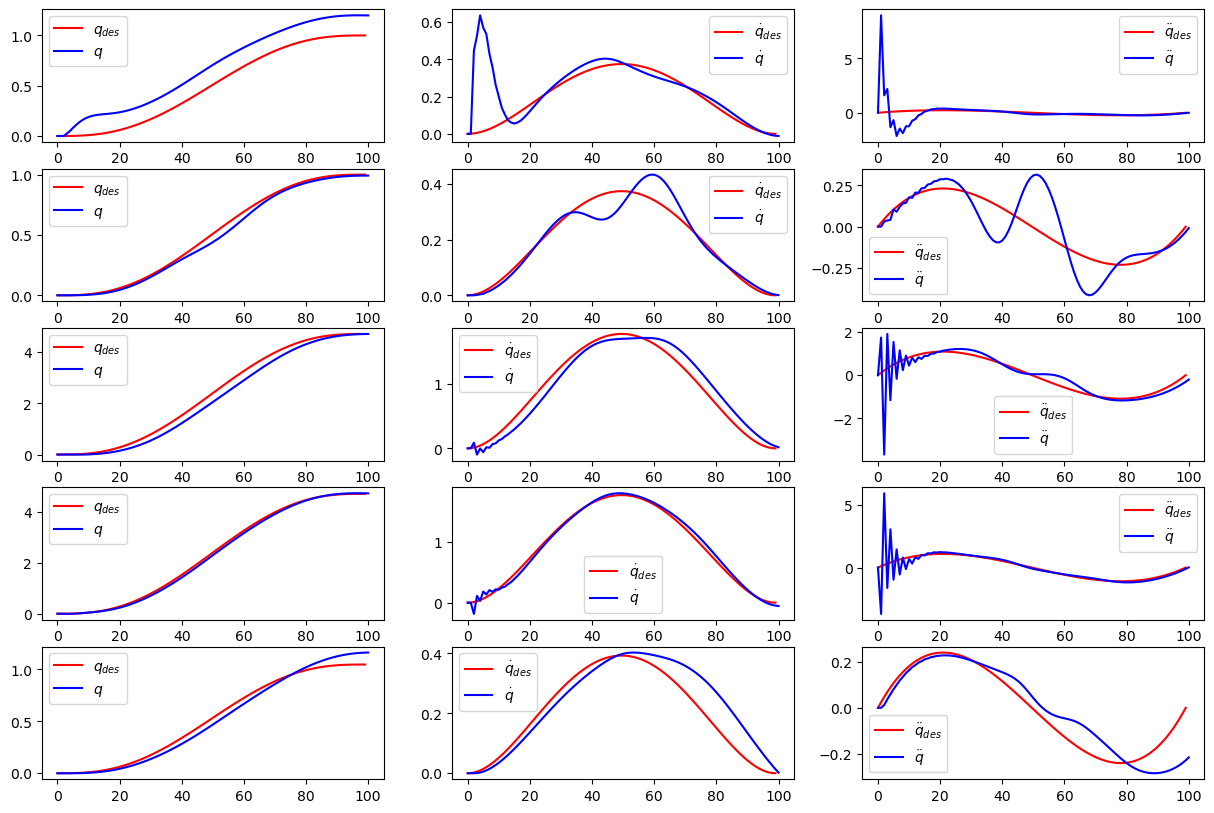

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 3, figsize=(15, 10))

for i in range(5):
    ax[i][0].plot(np.array(log['qd'])[:, i], color='red', label='$q_{des}$')
    ax[i][1].plot(np.array(log['dqd'])[:, i], color='red', label='$\dot{q}_{des}$')
    ax[i][2].plot(np.array(log['ddqd'])[:, i], color='red', label='$\ddot{q}_{des}$')
    ax[i][0].plot(np.array(log['q'])[:, i], color='blue', label='$q$')
    ax[i][1].plot(np.array(log['dq'])[:, i], color='blue', label='$\dot{q}$')
    ax[i][2].plot(np.array(log['ddq'])[:, i], color='blue', label='$\ddot{q}$')

for i in range(5):
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][2].legend()

# plt.savefig('assets/control1.png')
plt.show()

# Linearized Control

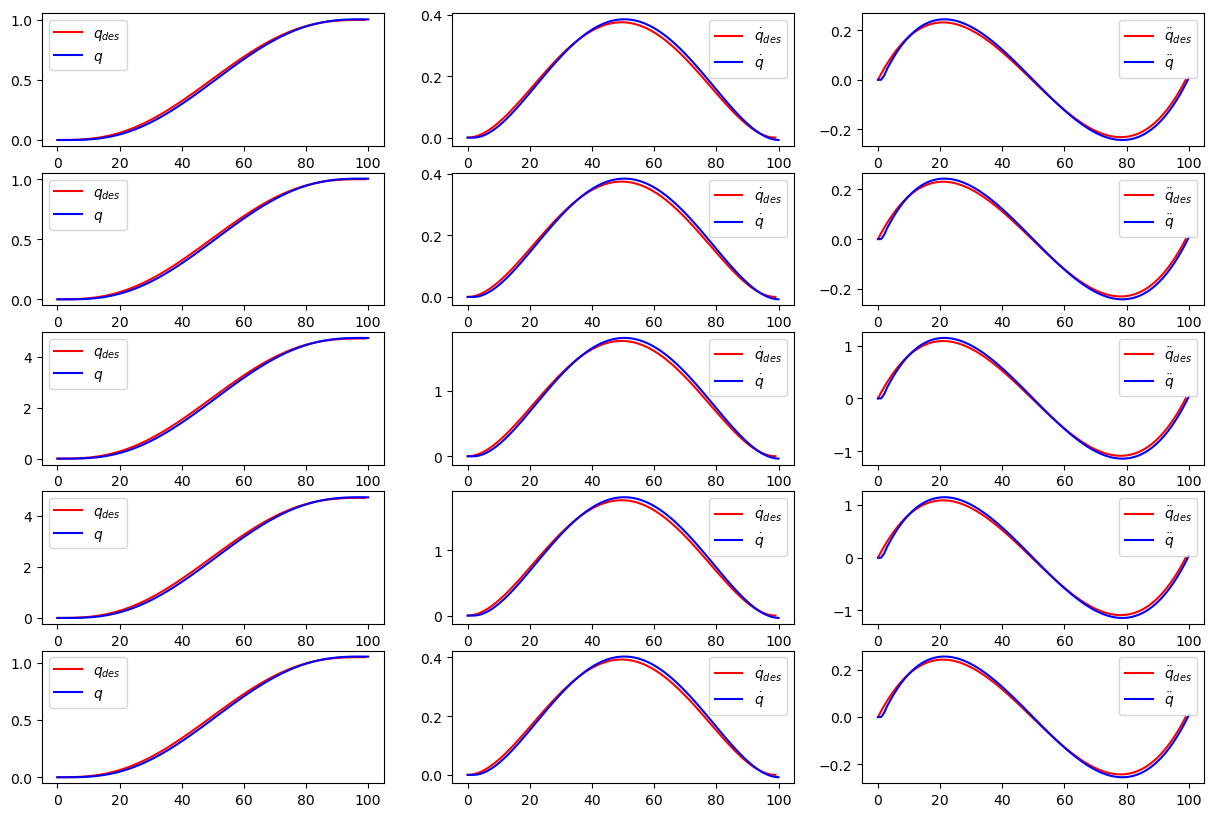

In [50]:
fig, ax = plt.subplots(5, 3, figsize=(15, 10))

for i in range(5):
    ax[i][0].plot(np.array(llog['qd'])[:, i], color='red', label='$q_{des}$')
    ax[i][1].plot(np.array(llog['dqd'])[:, i], color='red', label='$\dot{q}_{des}$')
    ax[i][2].plot(np.array(llog['ddqd'])[:, i], color='red', label='$\ddot{q}_{des}$')
    ax[i][0].plot(np.array(llog['q'])[:, i], color='blue', label='$q$')
    ax[i][1].plot(np.array(llog['dq'])[:, i], color='blue', label='$\dot{q}$')
    ax[i][2].plot(np.array(llog['ddq'])[:, i], color='blue', label='$\ddot{q}$')

for i in range(5):
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][2].legend()

# plt.savefig('assets/control2.png')
plt.show()

# Simulation

## Bad Control Simulation

In [51]:
q1 = np.array(log['q'])[:, 0]
q2 = np.array(log['q'])[:, 1]
q3 = np.array(log['q'])[:, 2]
q4 = np.array(log['q'])[:, 3]
q5 = np.array(log['q'])[:, 4]

In [52]:
ee_q1 = np.array(log['qd'])[:, 0]
ee_q2 = np.array(log['qd'])[:, 1]
ee_q3 = np.array(log['qd'])[:, 2]
ee_q4 = np.array(log['qd'])[:, 3]
ee_q5 = np.array(log['qd'])[:, 4]

ee_pos = []
for i in range(len(ee_q1)):
    new_com = sp.Matrix(coms[4]).subs({qs[1]: ee_q1[i], qs[2]: ee_q2[i], qs[3]: ee_q3[i], qs[4]: ee_q4[i], qs[5]: ee_q5[i]})
    new_com = new_com.subs({ls[1]: 1, ls[2]: 1, ls[3]: 1, ls[4]: 1, ls[5]: 1})
    new_com = new_com.evalf()
    new_com = new_com[0:3, 3]
    ee_pos.append(new_com)

ee_pos = np.array(ee_pos)

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.view_init(-30, 10)
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
ax.set_zlim(-1, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xs = [0.0, 0.0, 1.0, 1.0, 2.0]
ys = [0.0, 0.0, 0.0, 0.0, 0.0]
zs = [0.0, 1.0, 1.0, 2.0, 2.0]

mech_joints = []
mech_links = []
mech_labels = []
trace = []
cur_ind = 0

ax.plot(ee_pos[:, 0].T[0], ee_pos[:, 1].T[0], ee_pos[:, 2].T[0], color='green')

def update_model(frame):
    global cur_ind

    com_f = []
    for i in range(5):
        new_com = sp.Matrix(coms[i])
        new_com = new_com.subs({qs[1]: q1[cur_ind], qs[2]: q2[cur_ind], qs[3]: q3[cur_ind], qs[4]: q4[cur_ind], qs[5]: q5[cur_ind]})
        new_com = new_com.subs({ls[i]: 1 for i in range(0, 6)})
        new_com = new_com.evalf()
        new_com = new_com[0:3, 3]
        com_f.append(new_com)

    cur_ind += 1

    while not len(mech_links) == 0:
        mech_links[-1][0].remove()
        mech_links.pop()

    while not len(mech_joints) == 0:
        mech_joints[-1].remove()
        mech_joints.pop()

    while not len(mech_labels) == 0:
        mech_labels[-1].remove()
        mech_labels.pop()

    
    mech_links.extend(
        [ax.plot([com_f[i][0], com_f[i + 1][0]], [com_f[i][1], com_f[i + 1][1]], [com_f[i][2], com_f[i + 1][2]], color='red') for i in range(4)]
    )
    if (cur_ind - 1) % 4 == 0:
        trace.extend(
            [ax.plot(com_f[4][0], com_f[4][1], com_f[4][2], '+', color='blue', markersize=3)[0]]
        )
    mech_joints.extend(
        [ax.plot(com_f[i][0], com_f[i][1], com_f[i][2], 'o', color='black')[0] for i in range(5)]
    )

    return []

anim = FuncAnimation(fig, update_model, frames=np.linspace(0, 5, 99), blit=True)

anim.save('assets/sim1.gif', dpi=300, writer=PillowWriter(fps=60))
plt.close('all')

## Linearized Control Simulation

In [ ]:
q1 = np.array(llog['q'])[:, 0]
q2 = np.array(llog['q'])[:, 1]
q3 = np.array(llog['q'])[:, 2]
q4 = np.array(llog['q'])[:, 3]
q5 = np.array(llog['q'])[:, 4]

In [ ]:
ee_q1 = np.array(llog['qd'])[:, 0]
ee_q2 = np.array(llog['qd'])[:, 1]
ee_q3 = np.array(llog['qd'])[:, 2]
ee_q4 = np.array(llog['qd'])[:, 3]
ee_q5 = np.array(llog['qd'])[:, 4]

ee_pos = []
for i in range(len(ee_q1)):
    new_com = sp.Matrix(coms[4]).subs({qs[1]: ee_q1[i], qs[2]: ee_q2[i], qs[3]: ee_q3[i], qs[4]: ee_q4[i], qs[5]: ee_q5[i]})
    new_com = new_com.subs({ls[1]: 1, ls[2]: 1, ls[3]: 1, ls[4]: 1, ls[5]: 1})
    new_com = new_com.evalf()
    new_com = new_com[0:3, 3]
    ee_pos.append(new_com)

ee_pos = np.array(ee_pos)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.view_init(-30, 10)
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
ax.set_zlim(-1, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xs = [0.0, 0.0, 1.0, 1.0, 2.0]
ys = [0.0, 0.0, 0.0, 0.0, 0.0]
zs = [0.0, 1.0, 1.0, 2.0, 2.0]

mech_joints = []
mech_links = []
mech_labels = []
trace = []
cur_ind = 0

ax.plot(ee_pos[:, 0].T[0], ee_pos[:, 1].T[0], ee_pos[:, 2].T[0], color='green')

def update_model(frame):
    global cur_ind

    com_f = []
    for i in range(5):
        new_com = sp.Matrix(coms[i])
        new_com = new_com.subs({qs[1]: q1[cur_ind], qs[2]: q2[cur_ind], qs[3]: q3[cur_ind], qs[4]: q4[cur_ind], qs[5]: q5[cur_ind]})
        new_com = new_com.subs({ls[i]: 1 for i in range(0, 6)})
        new_com = new_com.evalf()
        new_com = new_com[0:3, 3]
        com_f.append(new_com)

    cur_ind += 1

    while not len(mech_links) == 0:
        mech_links[-1][0].remove()
        mech_links.pop()

    while not len(mech_joints) == 0:
        mech_joints[-1].remove()
        mech_joints.pop()

    while not len(mech_labels) == 0:
        mech_labels[-1].remove()
        mech_labels.pop()

    
    mech_links.extend(
        [ax.plot([com_f[i][0], com_f[i + 1][0]], [com_f[i][1], com_f[i + 1][1]], [com_f[i][2], com_f[i + 1][2]], color='red') for i in range(4)]
    )
    if (cur_ind - 1) % 4 == 0:
        trace.extend(
            [ax.plot(com_f[4][0], com_f[4][1], com_f[4][2], '+', color='blue', markersize=3)[0]]
        )
    mech_joints.extend(
        [ax.plot(com_f[i][0], com_f[i][1], com_f[i][2], 'o', color='black')[0] for i in range(5)]
    )

    return []

anim = FuncAnimation(fig, update_model, frames=np.linspace(0, 5, 99), blit=True)

anim.save('assets/sim2.gif', dpi=300, writer=PillowWriter(fps=60))
plt.close('all')